# MLverify: Applying learned model to actual image rasters
Tony Cannistra | Feb 2018

----
We've got a trained model from [here](./ml-v1.ipynb) and we're going to run the pixels of an image through it and see how the result looks. 


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.externals.joblib import load
from sklearn.preprocessing import StandardScaler
import numpy as np

import rasterio as rio
from rasterio import plot
from rasterio.features import shapes
import cartopy.crs as ccrs
import cartopy.feature as feature

from os import path
from glob import glob
import zipfile
from xml.dom import minidom



%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 19
plt.rcParams['figure.figsize'] = (27, 9)
plt.rcParams['font.size'] = 12

## Load the Model

In [4]:
modelfile = "./snowcover-model.pkl"
model = load(modelfile)



## Choose an image. 
We'll start with a snow-covered one. 

In [23]:
imagedir = "../images/"
images = glob(path.join(imagedir, 'snow', "*.zip"))

In [24]:
def openZippedImage(z, coeffs=True):
    archive = zipfile.ZipFile(z)
    imagef = [f for f in archive.namelist() if "AnalyticMS_clip.tif" in f][0]
    metaf  = [f for f in archive.namelist() if ".xml" in f][0]
    image = rio.open(archive.extract(imagef))
    
    if not coeffs: return(image)
    
    meta = minidom.parse(archive.extract(metaf))
    nodes = meta.getElementsByTagName("ps:bandSpecificMetadata")

    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
    
    return((image, coeffs))

In [25]:
#randimage = np.random.choice(images, 1)[0]
randimage = "../images/snow/1392_20170507_181759_0e30.zip"
print(randimage)
image, coeffs = openZippedImage(randimage)

##numblocks = len(src.block_shapes)

# b1win = src.block_windows(1)
# b2win = src.block_windows(2)
# b3win = src.block_windows(3)
# b4win = src.block_windows(4)

# for i in enumerate(src.block_shapes, 1):
#     b1 = image.read(1, window=next(b1win)[1])
#     b2 = image.read(2, window=next(b2win)[1])
#     b3 = image.read(3, window=next(b3win)[1])
#     b4 = image.read(4, window=next(b4win)[1])
#     stack = np.stack([b1, b2, b3, b4], axis=2)
#     ogshape = stack.shape

#     preds = model.predict(StandardScaler().fit_transform(stack.reshape(-1, 4)))
#     plt.imshow(preds.reshape(ogshape[:2]), cmap='Blues')
#     plt.show()

b1 = image.read(1)
b2 = image.read(2)
b3 = image.read(3)
b4 = image.read(4)

b1_toa = b1 * coeffs[1]
b2_toa = b2 * coeffs[2]
b3_toa = b3 * coeffs[3]
b4_toa = b4 * coeffs[4]

ndsi = np.nan_to_num((b2_toa - b4_toa)/(b2_toa + b4_toa))

stack = np.stack([b1, b2, b3, b4], axis=2)
toastack = np.stack([b3_toa, b2_toa, b1_toa], axis=2)

print(np.min(ndsi), np.max(ndsi))

../images/snow/1392_20170507_181759_0e30.zip
-0.54974144604874 0.1483454047764883


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


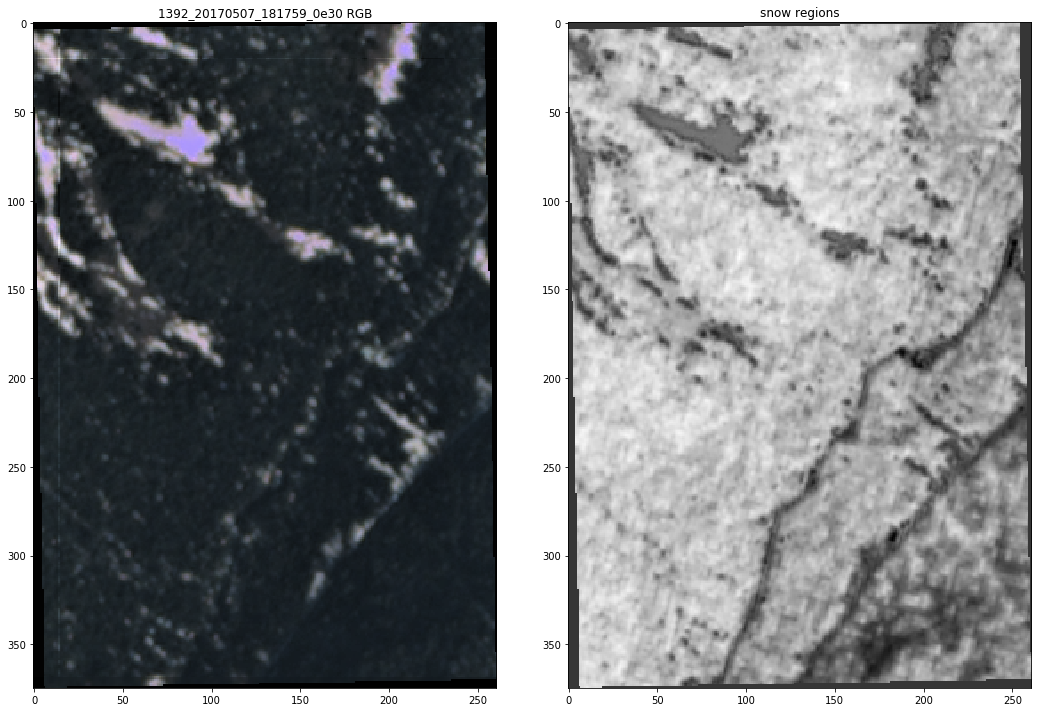

In [19]:
#toastack = np.stack([, b1_toa, b3_toa], axis=2)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))
from skimage.exposure import equalize_adapthist as hist
from skimage.filters import threshold_minimum as threshold_
ax1.imshow(hist(toastack))
ax1.set_title(path.basename(randimage).split(".")[0] + " RGB")
thresh = threshold_(ndsi)
thresh_ndsi = ndsi
i = ax2.imshow( thresh_ndsi, cmap='binary')
ax2.set_title('snow regions')

plt.tight_layout()
#plt.savefig("../figures/{}_ndsi.png".format(path.basename(randimage).split(".")[0]), dpi=100, transparent=True)

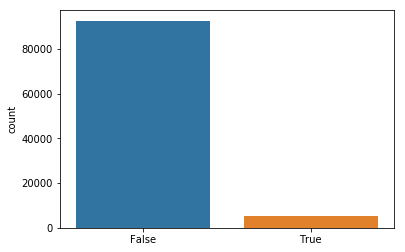

In [14]:
thresh = threshold_(ndsi)
sns.countplot(ndsi.ravel() >= thresh)

In [26]:
# selects band 2 and 4
#stack_ = stack[:300, :300, [1,3]]
stack_ = stack[:300, :300]

print(stack_.shape)
# add ndsi
#stack_ = np.append(stack_, ndsi[:300, :300][...,None], axis=2)

print(stack_.shape)

(300, 261, 4)
(300, 261, 4)


In [27]:

scaler = StandardScaler()
X = stack_
pred = model.predict(StandardScaler().fit_transform(stack_.reshape(-1, 4))).reshape(stack_.shape[:2])


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


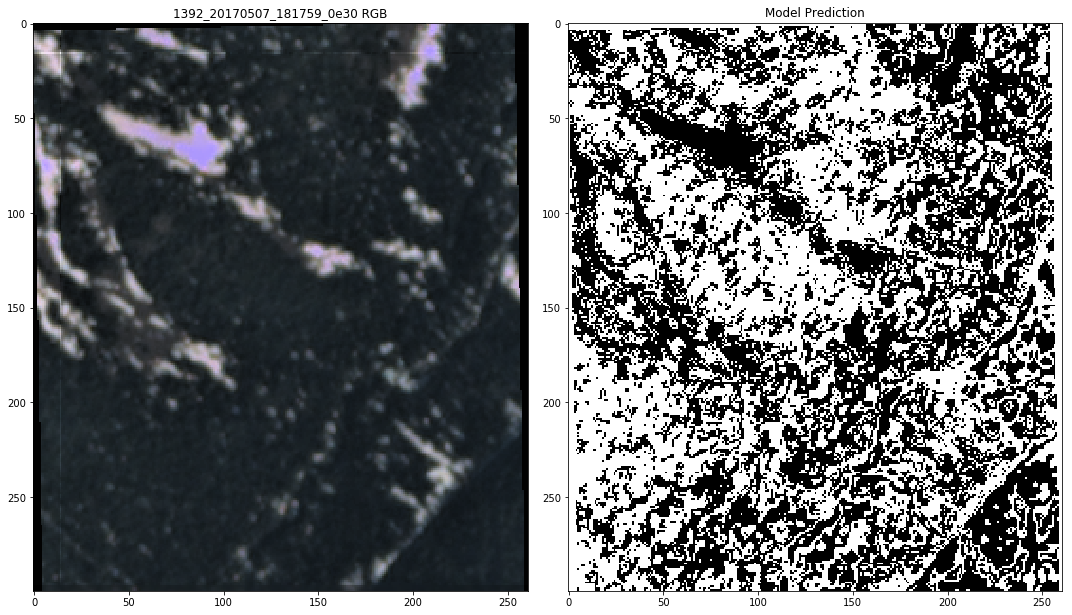

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[1].imshow(pred, cmap='binary_r')
axes[1].set_title("Model Prediction")
axes[0].imshow(hist(toastack[:300, :300, :]))
axes[0].set_title(path.basename(randimage).split(".")[0] + " RGB")
plt.tight_layout()
plt.savefig("../figures/{}_model.png".format(path.basename(randimage).split(".")[0]), dpi=100, transparent=True, bbox='tight')

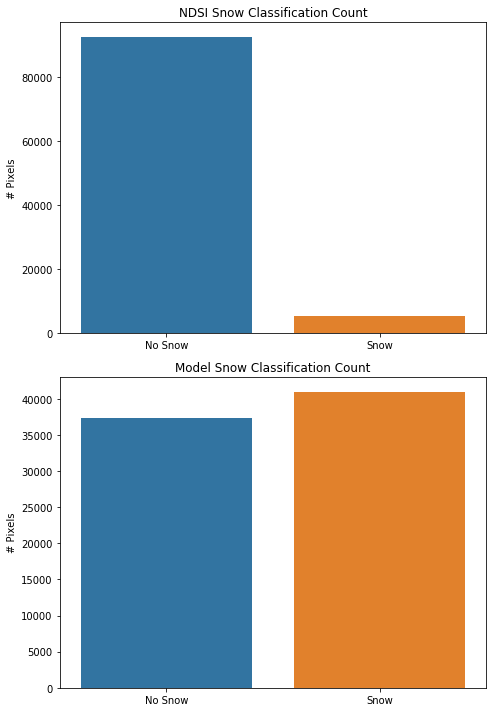

In [32]:
fig, ax = plt.subplots(2,1, figsize=(7,10))
ax[0].set_title("NDSI Snow Classification Count")
thresh = threshold_(ndsi)
sns.countplot(ndsi.ravel() > thresh, ax=ax[0])
ax[0].set_ylabel("# Pixels")
ax[0].set_xticklabels(["No Snow", "Snow"])

ax[1].set_title("Model Snow Classification Count")
sns.countplot(pred.ravel(), ax=ax[1])
ax[1].set_ylabel("# Pixels")
ax[1].set_xticklabels(["No Snow", "Snow"])
plt.tight_layout()
#plt.savefig("../figures/{}_classificationcount.png".format(path.basename(randimage).split(".")[0]), dpi=100, transparent=True, bbox='tight')

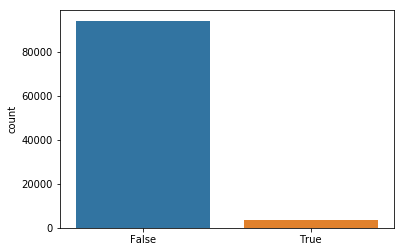

In [33]:
sns.countplot(thresh_ndsi.ravel() == 0)

In [35]:
predprobs = model.predict_proba(StandardScaler().fit_transform(stack_.reshape(-1, 4)))


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


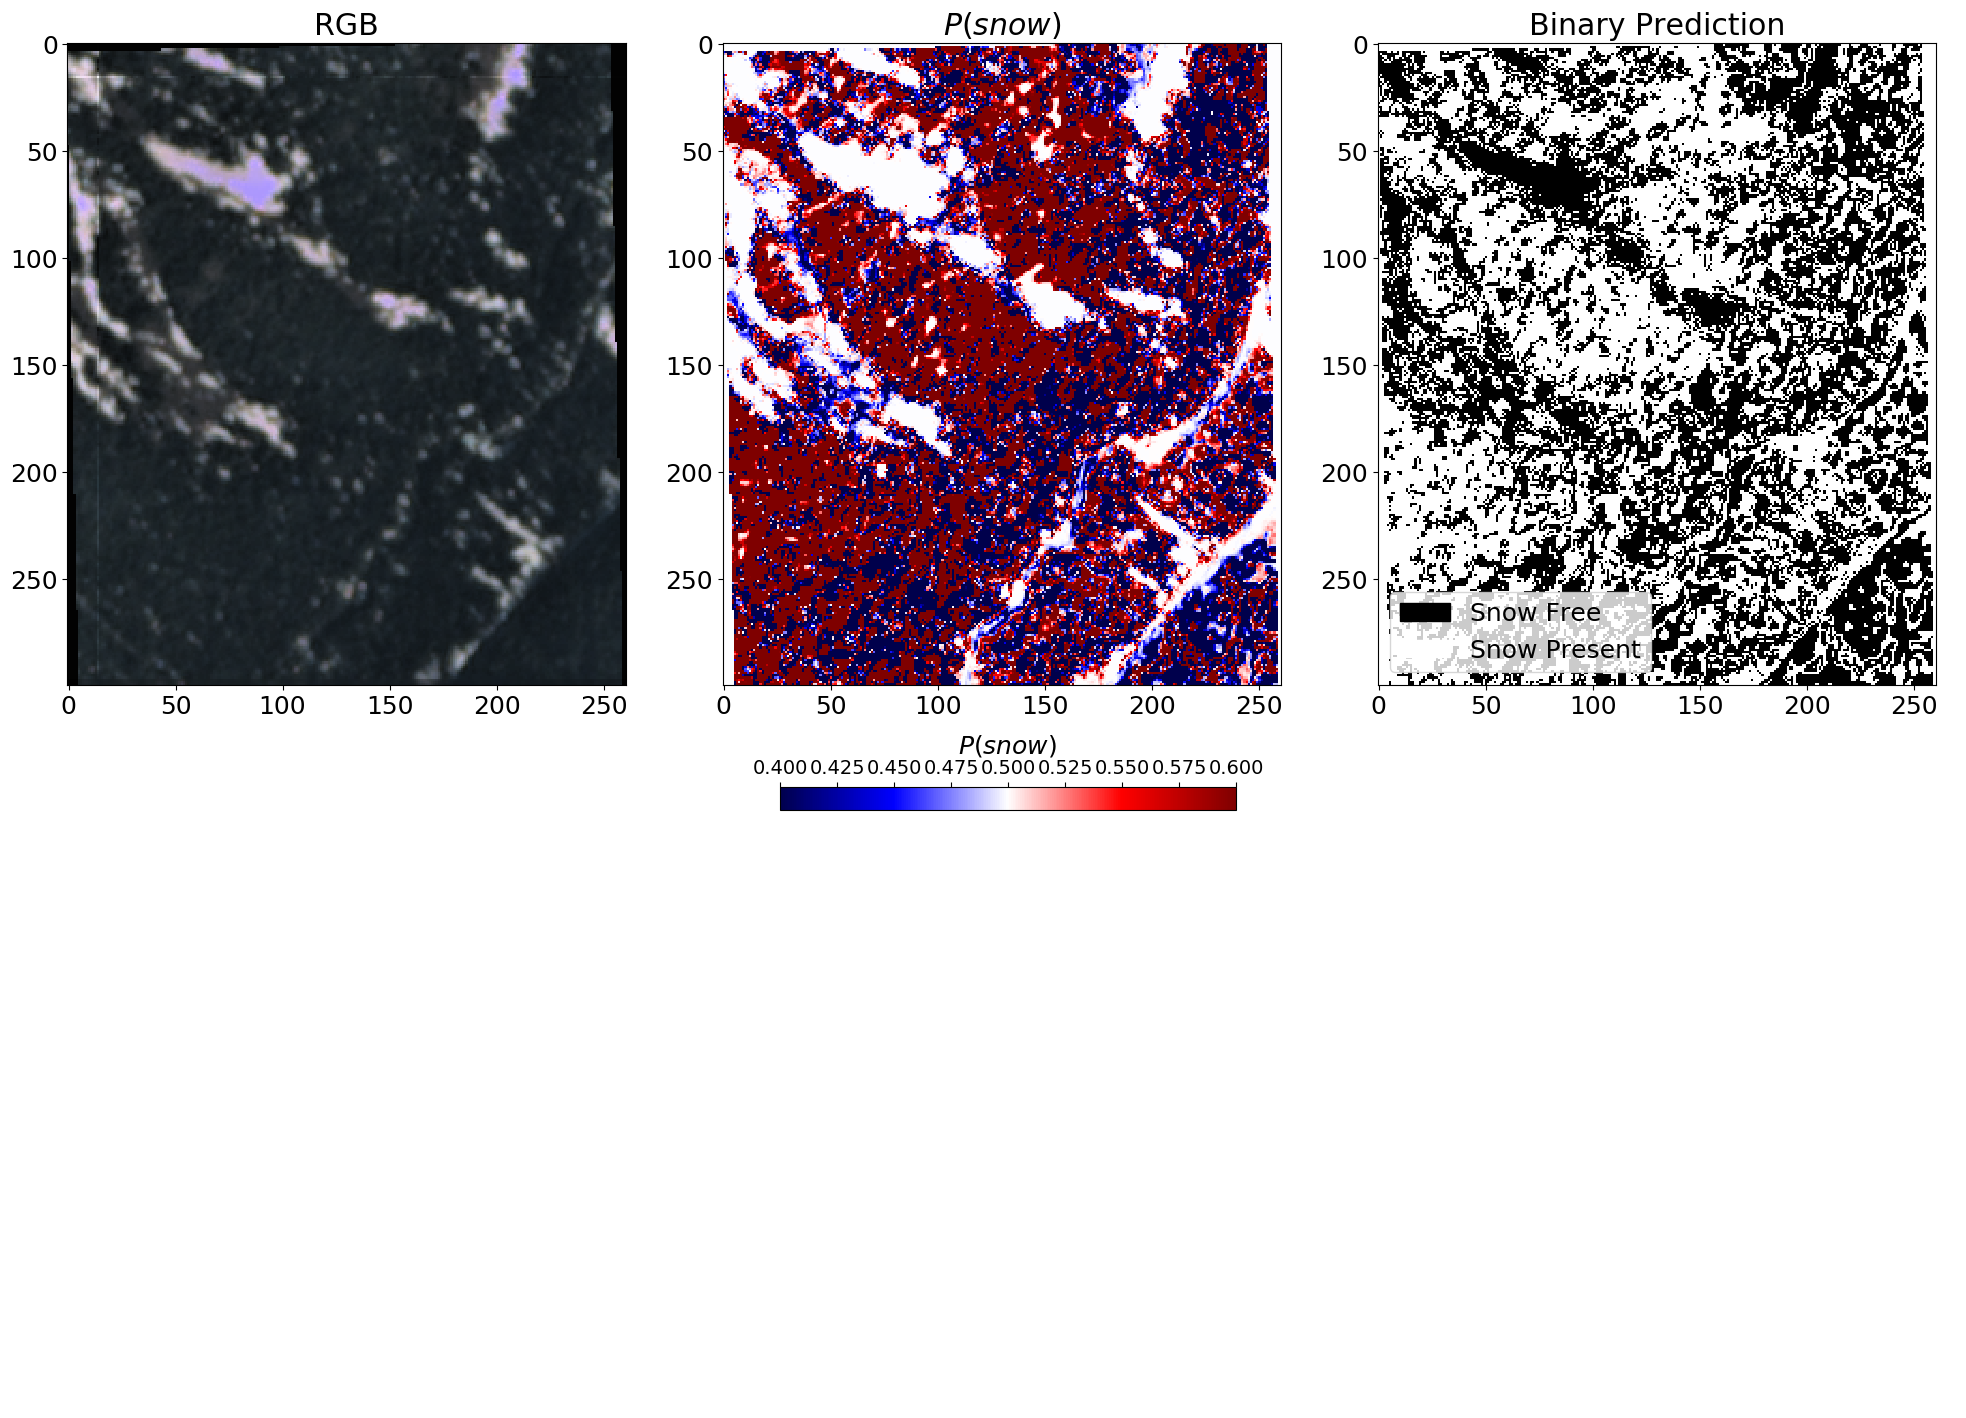

In [50]:

_pred = predprobs[:,1]
#_pred[(predprobs[:,1] > 0.49) & (predprobs[:,1] < 0.51)] = 1

plt.rcParams['font.size'] = 18

fig, axs = plt.subplots(2,3, figsize=(20,15))
axs[0,0].imshow(hist(toastack[:300, :300, :]))
axs[0,0].set_title("RGB")

a = axs[0,1].imshow(_pred.reshape(stack_.shape[:2]), cmap='seismic', vmin=0.4, vmax=0.6)
axs[0,1].set_title("$P(snow)$")

a1 = axs[0,2].imshow(pred, cmap='binary_r')
axs[0,2].set_title("Binary Prediction")
off_patch = patches.Patch(color='black', label='Snow Free')
on_patch = patches.Patch(color='white', label='Snow Present')


axs[0,2].legend(handles=[off_patch, on_patch], loc='lower left')
cb = plt.colorbar(a, pad=0.05, location='top', use_gridspec=False, ax=axs[1,1])
cb.ax.tick_params(labelsize=14)
cb.set_label("$P(snow)$")


axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')

plt.subplots_adjust(hspace=0.02)
plt.tight_layout(h_pad=-7)

plt.savefig("../figures/{}allbands_allresults.png".format(path.basename(randimage).split(".")[0]), dpi=200, transparent=True, bbox='tight')

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


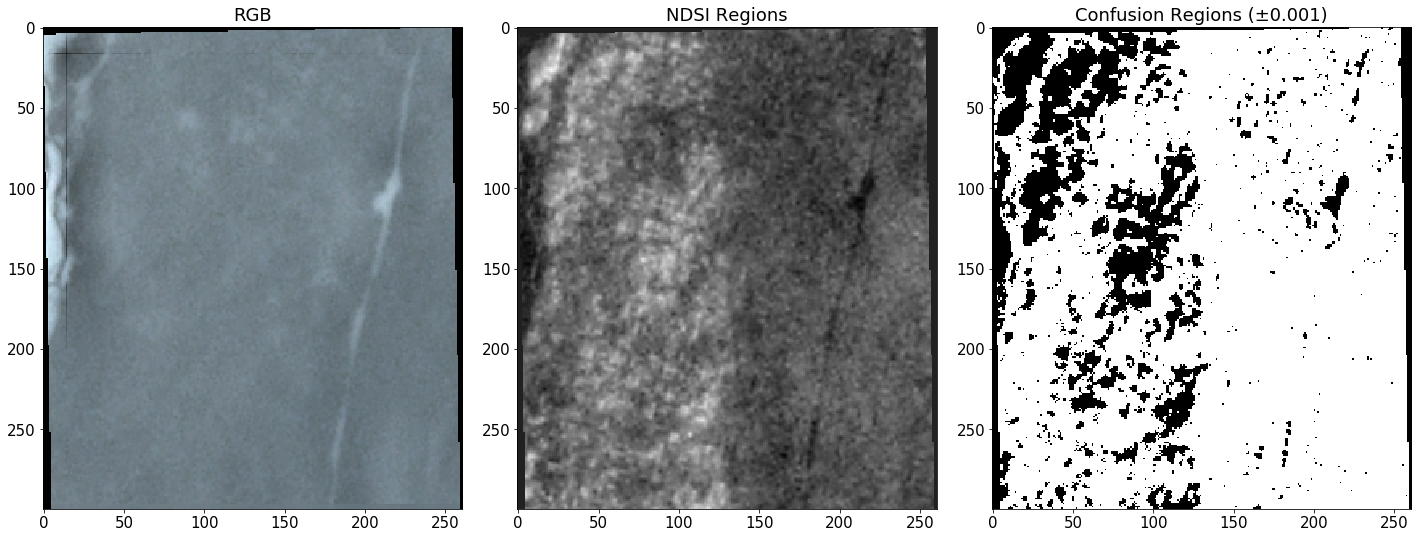

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(20,15))

axes[0].imshow(hist(toastack[:300, :300, :]))
axes[0].set_title("RGB")

axes[1].imshow( thresh_ndsi[:300, :300], cmap='binary')
axes[1].set_title("NDSI Regions")

axes[2].imshow(((_pred <= 0.501) & (_pred >= 0.499)).astype('int8').reshape(stack_.shape[:2]), cmap='binary')
axes[2].set_title("Confusion Regions (±0.001)")

plt.tight_layout()

plt.savefig("../figures/{}-ndsi-confusion.png".format(path.basename(randimage).split(".")[0]), dpi=200, transparent=True, bbox='tight')

In [ ]:
xmin, xmax, ymin, ymax = 0, 300, 0, 260
extent = xmin, xmax, ymin, ymax

fig = plt.figure(frameon=False)
im2 = plt.imshow(hist(toastack[:300, :260, :]), extent=extent)
plt.imshow(_pred.reshape(stack_.shape[:2]), cmap="Blues", extent=extent, alpha=0.9)
#im1 = plt.imshow(pred, cmap='Blues', extent=extent, alpha=0.1)


In [48]:
from rasterio.features import shapes
sh = list(shapes(pred.reshape(stack_.shape[:2]).astype('int16'), connectivity=4, transform=image.transform))

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/rasterio/features.py:102: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [57]:
import geopandas as gpd
from shapely.geometry import shape
polys = gpd.GeoDataFrame(geometry=[shape(s[0]) for s in sh])
polys['area'] = polys.geometry.area
polys = polys.sort_values('area', ascending=False)


3378

In [105]:
image.transform


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


[621348.0, 3.0, 0.0, 5194602.0, 0.0, -3.0]

In [65]:
toastack.shape

(375, 260, 3)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [ ]:
sns.countplot(thresh_ndsi.ravel())